In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.tag import StanfordPOSTagger
from nltk import word_tokenize
from nltk.internals import find_jars_within_path
import nltk
import sklearn.model_selection
from collections import Counter
import sklearn.feature_extraction.text as skt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import io
import re
import string
import tqdm
#import tensorflow as tf
#from tensorflow.keras import layers

#import torch
#import transformers

import pyhealth
from pyhealth.medcode import InnerMap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords as STOP_WORDS

from sklearn.linear_model import LogisticRegression


In [35]:
root = "/Users/ashleyroakes/Desktop/"
mim_root = root + "mimic-iii-clinical-database-1.4/"

#root = "../data/"
#mim_root = "../data/"

# Data Pre-processing
## Read in Discharge Notes

In [36]:
notes = mim_root + "NOTEEVENTS.csv.gz"

notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False, 
                       usecols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION','TEXT'])\
                      .query("CATEGORY == 'Discharge summary'")\
                      .query("DESCRIPTION == 'Report'")

# Should be 55,177 records
print("Number of discharge summaries: ", + len(notes_df))

notes_df.head()

<ipython-input-36-44e46582d5d0>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  notes_df = pd.read_csv(notes, compression='gzip', error_bad_lines=False,


Number of discharge summaries:  55177


,SUBJECT_ID,HADM_ID,CATEGORY,DESCRIPTION,TEXT
0,22532,167853.0,Discharge summary,Report,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Report,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Report,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Report,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Report,Admission Date: [**2162-3-3**] D...


## Read in Patient Diagnoses

In [37]:
diag = mim_root + "DIAGNOSES_ICD.csv.gz"

diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\
                    .dropna()\
                    .groupby('HADM_ID')['ICD9_CODE']\
                    .unique()\
                    .reset_index()

diag_df.head()

<ipython-input-37-64ff0258cef1>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  diag_df = pd.read_csv(diag, compression='gzip', error_bad_lines=False)\


,HADM_ID,ICD9_CODE
0,100001,"[25013, 3371, 5849, 5780, V5867, 25063, 5363, ..."
1,100003,"[53100, 2851, 07054, 5715, 45621, 53789, 4019,..."
2,100006,"[49320, 51881, 486, 20300, 2761, 7850, 3090, V..."
3,100007,"[56081, 5570, 9973, 486, 4019]"
4,100009,"[41401, 99604, 4142, 25000, 27800, V8535, 4148..."


## Read in ICD9 Dictionary

In [38]:
icd = mim_root + "D_ICD_DIAGNOSES.csv.gz"
icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)


icd_df.head()

<ipython-input-38-0e824f7752d2>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  icd_df = pd.read_csv(icd, compression='gzip', error_bad_lines=False)


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


## Merge datasets by HADM_ID

In [39]:
df = pd.merge(diag_df, notes_df, on='HADM_ID', how='inner')

# Should be 55177-5 = 55172
len(df)

55172

## Substitute special sequences,  Filter HoPI sections, & Tokenize

### Identify HOPI sections & Substitute Special Sequences: These special sequences were identified and replaced by the first token in the sequence, e.g. "[**Hospital1 18**]" was replaced by ‘Hospital1’.

In [40]:
def process_notes(st):
    s  = "History of Present Illness"
    s1 = "HISTORY OF PRESENT ILLNESS|HISTORY OF THE PRESENT ILLNESS|\nHISTORY:|present illness|Present Illness|PRESENT ILLNESS"
    
    match  = re.search(s, st)
    match1 = re.search(s1, st)
    
    if (match is not None) or (match1 is not None):
        if match is not None:
            st = st.split(s, 1)[1]
            e = "\n\n\n"
            n = st.split(e, 1)[0]
    
        elif match1 is not None: 
            st = st.split(match1[0], 1)[1]
            e = re.search(r"\n[\s\w]+:", st)[0]
            n = st.split(e, 1)[0]
        
        # Replace special strings with ""
        rep = re.findall(r"\[\*\*([a-zA-Z0-9]*)", n)
        strt = [m.start() for m in re.finditer("\[\*\*([a-zA-Z0-9]*)", n)]
        end = [m.end() for m in re.finditer("([a-zA-Z0-9]*)\*\*\]", n)]

        for i in range(len(rep)):
            n = n[:strt[i]] + rep[i] + " " + n[end[i] + 1:]
        
    else: 
        n = ''
    return n

In [41]:
df['HOPI'] = df["TEXT"].map(lambda t: process_notes(t))

### Number of missing HOPI sections

In [51]:
# Detect history of present illness in text (n = 2641 records without HoPI data)
df_hopi = df[df["HOPI"] != ""].reset_index(drop = True)

missing = df[df["HOPI"] == ""].reset_index(drop = True)

len(missing)

# Should be 2641 records
print("Notes without HOPI sections: " + str(len(missing)))


Notes without HOPI sections: 1867


### Initialize Stanford Tokenizer

In [52]:
# Add the jar and model via their path (instead of setting environment variables):
jar = root + 'stanford-postagger-full-2020-11-17/stanford-postagger.jar'
model = root + 'stanford-postagger-full-2020-11-17/models/english-left3words-distsim.tagger'

pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

# Add other jars from Stanford directory
stanford_dir = pos_tagger._stanford_jar.rpartition('/')[0]
stanford_jars = find_jars_within_path(stanford_dir)
pos_tagger._stanford_jar = ':'.join(stanford_jars)

### Tokenize, Remove Punctuation and Stop Words

In [53]:
# THIS CELL WILL BE REMOVED 
# For testing out other possible HOPI section headers

#PREOPERATIVE DIAGNOSIS (n = 6)
#ADMISSION DIAGNOSIS(es) (n = 38)(n = 45)
#ADMITTING DIAGNOSES (n = 7)
#HOSPITAL COURSE
#REASON FOR ADMISSION

ms = missing["TEXT"].map(lambda t: re.search("\nHISTORY:", t))
m = missing[~ms.isna()].reset_index()

cap = 138
lw = 15
lwlw = 12
hpi = 2
crs = 951
print(len(m))
#print(m["TEXT"][1])

#missing["TEXT"].to_csv(root + "no hopi.csv"

#df["HOPI"][8]


0


In [54]:
# Remove punctuation, non-characters, etc. 
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('\[\*\*[^\]]*\*\*\]', '', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('<[^>]*>', '', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub('[\W]+', ' ', x))
df_hopi["HOPI"] = df_hopi["HOPI"].apply(lambda x: re.sub("\d+", " ", x))

# Tokenize
df_hopi['tokens'] = df_hopi["HOPI"].map(lambda n: word_tokenize(n))

### Truncate at 500 tokens

In [55]:
# Truncate records with more than 500 tokes (n = 1143)
count = df_hopi['tokens'].map(lambda c: len(np.unique(c)))

df_hopi["trunc"] = df_hopi['tokens'].map(lambda c: np.unique(c)[0:500])

print("Number of HOPI sections >= 500 tokens: " + str(len(df_hopi[count>=500])))

Number of HOPI sections >= 500 tokens: 1656


## Plot a histogram of the Number of tokens in each HoPI document, after data preprocessing.

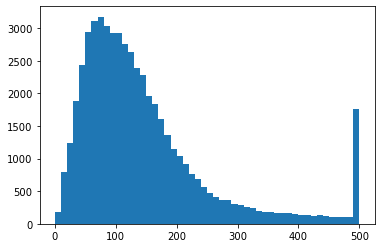

In [56]:
df_hopi["trunc_len"] = df_hopi['trunc'].map(lambda c: len(c))

plt.hist(df_hopi["trunc_len"], np.arange(0, 501, 10))
plt.show()

## Split data in train, valid, and test sets
### training (38,588 records, 69.9%), validation (5536 records, 10.0%) and testing (11,048 records, 20.0%) folds

In [57]:
# Random split
train, tst = sklearn.model_selection.train_test_split(df_hopi, test_size= 0.3, random_state=42)

test, valid = sklearn.model_selection.train_test_split(tst, test_size= 0.33, random_state=42)

train = train.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
test = test.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)
valid = valid.reset_index(drop = True).drop(["CATEGORY", "DESCRIPTION"], axis = 1)

In [58]:
# Get percentage of data in each set

## Count number of tokens in the training dataset (n = ~92,468 tokens)

In [59]:
# Count occurence of tokens that are in the training dataset
n = len(np.unique(np.concatenate(train["trunc"].values)))
occ = Counter(np.concatenate(train["trunc"].values))
             
# Tokens that occur >= 5 times are in the study vocabulary (should be ~19,503)
vocab = [k for k,v in occ.items() if v >= 5]
len(vocab)

# Assign a unique integer ID for each token in the study vocabulary 
vocab_lookup = dict(zip(vocab, np.arange(0, len(vocab), 1)))

# Convert each HoPI document to a 1D array of integers using this index
#df_hopi["trunc_idx"] = df_hopi["trunc"].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])

train["trunc_idx"] =  train["trunc"].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
valid["trunc_idx"] =  valid["trunc"].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])
test["trunc_idx"] =  test["trunc"].map(lambda x: [vocab_lookup.get(i) for i in x if i in vocab_lookup.keys()])

# Document representation

In [137]:
# Represent clinical notes documents as TF-IDF representation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

def tfidf(df):
    pipe = Pipeline([('count', CountVectorizer(vocabulary = vocab, lowercase = False)),('tfid', TfidfTransformer(use_idf=True))]).fit(df["HOPI"].values)
    pipe['count'].transform(df["HOPI"].values).toarray()
    pipe['tfid'].idf_

    return pipe.transform(df["HOPI"].values)

# Create sparse matrix of size number of docs x words in vocab
tfidf_train = tfidf(train)
tfidf_valid = tfidf(valid)
tfidf_test = tfidf(test)


In [138]:
# Mean embedding representation

In [ ]:
# GRU representation

# Label representation

### Identify the hierarchical labels for each icd9 code

In [139]:
# Pull out the main ICD9 code (they are ordered for importance)
train["ICD_Main"] = train['ICD9_CODE'].map(lambda x: x[0])
valid["ICD_Main"] = valid['ICD9_CODE'].map(lambda x: x[0])
test["ICD_Main"] = test['ICD9_CODE'].map(lambda x: x[0])

In [141]:
# Use pyhealth library to find code hierarchy for the train, test, and valid datasets
icd9cm = InnerMap.load("ICD9CM")

def define_levels(x):
    lvls = []
    for l in x: 
        lvls.append(icd9cm.lookup(l))
    return lvls

# NEED TO REMOVE '001-999.99' FROM SOME OF THE ANCESTOR LISTS

def get_codes(df):
    df['icd_desc'] = df['ICD_Main'].map(lambda x: icd9cm.lookup(x))
    df['levels'] = df['ICD_Main'].map(lambda x:icd9cm.get_ancestors(x)[::-1])
    #df['lvls'] = df['levels'].map(lambda x: drop_top(x))
    df['levels_desc'] = df['levels'].map(lambda x: define_levels(x))

get_codes(train)
get_codes(valid)
get_codes(test)

In [60]:
# NEED TO REMOVE '001-999.99' FROM SOME OF THE ANCESTOR LISTS

#df['lvls'] = df['levels'].map(lambda x: drop_top(x))

In [142]:
train_labs = pd.concat([train, train['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1).rename(columns={0: "l1", 1: "l2", 2: "l3", 3: "l4" })
valid_labs = pd.concat([valid, valid['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1).rename(columns={0: "l1", 1: "l2", 2: "l3", 3: "l4" })
test_labs = pd.concat([test, test['levels_desc'].apply(pd.Series)], axis = 1).drop("levels_desc", axis = 1).rename(columns={0: "l1", 1: "l2", 2: "l3", 3: "l4" })

### TFIDF-Atomic

In [149]:
# Multinomial Logistic Regression from sklearn 

# L2 values to iterate over
L2 = np.logspace(.01, 100, num = 50)

# Multinomial Logistic Regression Model
tfidf_atomic = LogisticRegression(multi_class = 'multinomial', penalty = 'l2', max_iter = 1500, solver = "sag", random_state = 42)

#tfidf_atomic_L1 = tfidf.fit(tfidf_train, train['l1'])

### Mean-embedding representation

### GRU representation